# Evaluate Land Parcel Maximum Monthly NDVI using Statistical API

In [1]:
import os
import yaml
from munch import munchify

### _Setup configuration and environment_

In [2]:
# define repo name and get root working directory
repo = 'statistical'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]

# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'sentinel-2' )

In [3]:
# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'sentinel-2' )
cfg_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\apis\\statistical\\cfg\\sentinel-2'

In [4]:
# get pathname to configuration file
cfg_file = os.path.join( cfg_path, 's2-ndvi-maximum.yml' )

In [5]:
# print contents of configuration file
with open( cfg_file ) as f:
    print ( f.read() )

request:
    evalscript: |       
                //VERSION=3
                function setup() {
                    return {
                        input: [ {
                            bands: [
                                "B04",
                                "B08",
                                "SCL",
                                "dataMask"
                            ]
                        } ],
                        mosaicking: "ORBIT",
                        output: [
                            {
                                id: "data",
                                bands: ["monthly_max_ndvi"]
                            },
                            {
                                id: "dataMask",
                                bands: 1
                            } ]
                    }
                }
                function evaluatePixel(samples) {
                    var max = 0;
                    var hasData = 0;
                    for (var

In [6]:
# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )
config

Munch({'request': Munch({'evalscript': '//VERSION=3\nfunction setup() {\n    return {\n        input: [ {\n            bands: [\n                "B04",\n                "B08",\n                "SCL",\n                "dataMask"\n            ]\n        } ],\n        mosaicking: "ORBIT",\n        output: [\n            {\n                id: "data",\n                bands: ["monthly_max_ndvi"]\n            },\n            {\n                id: "dataMask",\n                bands: 1\n            } ]\n    }\n}\nfunction evaluatePixel(samples) {\n    var max = 0;\n    var hasData = 0;\n    for (var i=0;i<samples.length;i++) {\n        if (samples[i].dataMask == 1 && samples[i].SCL != 6 && samples[i].B04+samples[i].B08 != 0 ){\n            hasData = 1\n            var ndvi = (samples[i].B08 - samples[i].B04)/(samples[i].B08 + samples[i].B04);\n            max = ndvi > max ? ndvi:max;\n        }\n    }\n    return {\n        data: [max],\n        dataMask: [hasData]\n    }\n}\n', 'inputs': [M

### _Replicate use case results taken from Sentinel-Hub documentation_

In [7]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

coords = "[ [ [ 458085.878866, 5097236.833044 ], [ 457813.834156, 5096808.351383 ], [ 457979.897062, 5096313.767184 ],  [ 458146.639373, 5096405.411294 ], [ 458085.878866, 5097236.833044 ] ] ]"

df = pd.DataFrame([["Polygon", coords ]], columns=["type", "coords"])
gdf = gpd.GeoDataFrame( geometry=gpd.GeoSeries( Polygon(eval(df.coords.iloc[0])[0] ) ) )
gdf = gdf.set_crs( 32633 )
gdf

,geometry
0,"POLYGON ((458085.879 5097236.833, 457813.834 5..."


In [8]:
gdf = gdf.to_crs(4326)
bounds = gdf.bounds.values[ 0 ]
cx = (bounds[ 2 ] + bounds[ 0 ]) / 2.0
cy = (bounds[ 3 ] + bounds[ 1 ]) / 2.0
cx, cy

(14.457122499992728, 46.02326499999474)

In [9]:
import folium
m = folium.Map(location=[ cy, cx ], zoom_start=14, tiles='CartoDB positron')

for _, r in gdf.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
m

In [10]:
# define aggregation timeframe
from datetime import datetime
timeframe = { 'start' : datetime.strptime('2020-01-01', '%Y-%m-%d'), 
              'end' : datetime.strptime('2020-12-31', '%Y-%m-%d') }

In [11]:
# create instance of shclient class
from statisticalapi import Client
client = Client( config )

In [12]:
# submit request
gdf = gdf.to_crs( 32633 )
response = { '2020' : client.getStatistics( [ timeframe ], resolution=10, polygons=gdf, interval='P30D' ) }

In [13]:
response[ '2020' ]._dfs[ 0 ]

,id,interval_from,interval_to,data_monthly_max_ndvi_min,data_monthly_max_ndvi_max,data_monthly_max_ndvi_mean,data_monthly_max_ndvi_stDev,data_monthly_max_ndvi_sampleCount,data_monthly_max_ndvi_noDataCount
0,geom_0,2020-01-01,2020-01-31,0.475564,0.881286,0.639609,0.068449,3036,1192
1,geom_0,2020-01-31,2020-03-01,0.358025,0.872104,0.595635,0.073674,3036,1192
2,geom_0,2020-03-01,2020-03-31,0.448674,0.802126,0.587156,0.057052,3036,1192
3,geom_0,2020-03-31,2020-04-30,0.669223,0.915129,0.815762,0.033218,3036,1192
4,geom_0,2020-04-30,2020-05-30,0.805880,0.918788,0.888968,0.012977,3036,1192
5,geom_0,2020-05-30,2020-06-29,0.688319,0.877558,0.823141,0.026858,3036,1192
6,geom_0,2020-06-29,2020-07-29,0.832955,0.937048,0.903794,0.012791,3036,1192
7,geom_0,2020-07-29,2020-08-28,0.760216,0.905237,0.859046,0.016254,3036,1192
8,geom_0,2020-08-28,2020-09-27,0.740365,0.888938,0.822339,0.019577,3036,1192
9,geom_0,2020-09-27,2020-10-27,0.641610,0.825619,0.736814,0.028841,3036,1192


### _Results extracted from Sentinel-Hub documentation_

{'data': [{'interval': {'from': '2020-01-01T00:00:00Z',
    'to': '2020-01-31T00:00:00Z'},
   'outputs': {'data': {'bands': {'monthly_max_ndvi': {'stats': {'min': 0.4755639135837555,
        'max': 0.881286084651947,
        'mean': 0.6396090604381046,
        'stDev': 0.06844923487502963,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-01-31T00:00:00Z', 'to': '2020-03-01T00:00:00Z'},
   'outputs': {'data': {'bands': {'monthly_max_ndvi': {'stats': {'min': 0.3580246865749359,
        'max': 0.8721038103103638,
        'mean': 0.5956351390500386,
        'stDev': 0.07367438999713516,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-03-01T00:00:00Z', 'to': '2020-03-31T00:00:00Z'},
   'outputs': {'data': {'bands': {'monthly_max_ndvi': {'stats': {'min': 0.4486735761165619,
        'max': 0.8021259307861328,
        'mean': 0.5871563556072766,
        'stDev': 0.057052289003643133,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-03-31T00:00:00Z', 'to': '2020-04-30T00:00:00Z'},
   'outputs': {'data': {'bands': {'monthly_max_ndvi': {'stats': {'min': 0.6692230701446533,
        'max': 0.9151291251182556,
        'mean': 0.8157615211677142,
        'stDev': 0.033218066972707065,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-04-30T00:00:00Z', 'to': '2020-05-30T00:00:00Z'},
   'outputs': {'data': {'bands': {'monthly_max_ndvi': {'stats': {'min': 0.8058800101280212,
        'max': 0.9187881350517273,
        'mean': 0.8889683038965989,
        'stDev': 0.012977241049476852,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-05-30T00:00:00Z', 'to': '2020-06-29T00:00:00Z'},
   'outputs': {'data': {'bands': {'monthly_max_ndvi': {'stats': {'min': 0.6883189082145691,
        'max': 0.8775584697723389,
        'mean': 0.8231413116488706,
        'stDev': 0.026857728958053807,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-06-29T00:00:00Z', 'to': '2020-07-29T00:00:00Z'},
   'outputs': {'data': {'bands': {'monthly_max_ndvi': {'stats': {'min': 0.8329545259475708,
        'max': 0.9370484948158264,
        'mean': 0.9037939229264967,
        'stDev': 0.012790519558688863,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-07-29T00:00:00Z', 'to': '2020-08-28T00:00:00Z'},
   'outputs': {'data': {'bands': {'monthly_max_ndvi': {'stats': {'min': 0.7602161169052124,
        'max': 0.9052368998527527,
        'mean': 0.859046490422556,
        'stDev': 0.016254065036794822,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-08-28T00:00:00Z', 'to': '2020-09-27T00:00:00Z'},
   'outputs': {'data': {'bands': {'monthly_max_ndvi': {'stats': {'min': 0.7403650879859924,
        'max': 0.8889380693435669,
        'mean': 0.822339247532367,
        'stDev': 0.019577044702359023,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-09-27T00:00:00Z', 'to': '2020-10-27T00:00:00Z'},
   'outputs': {'data': {'bands': {'monthly_max_ndvi': {'stats': {'min': 0.6416097283363342,
        'max': 0.8256189227104187,
        'mean': 0.7368144742384923,
        'stDev': 0.02884084473079313,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-10-27T00:00:00Z', 'to': '2020-11-26T00:00:00Z'},
   'outputs': {'data': {'bands': {'monthly_max_ndvi': {'stats': {'min': 0.5424679517745972,
        'max': 0.9108409285545349,
        'mean': 0.7069293897671695,
        'stDev': 0.05380689467103403,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}},
  {'interval': {'from': '2020-11-26T00:00:00Z', 'to': '2020-12-26T00:00:00Z'},
   'outputs': {'data': {'bands': {'monthly_max_ndvi': {'stats': {'min': 0.0,
        'max': 0.14360177516937256,
        'mean': 0.04437006836957318,
        'stDev': 0.026757893384181577,
        'sampleCount': 3036,
        'noDataCount': 1192}}}}}}],
 'status': 'OK'}

<AxesSubplot:xlabel='interval_from'>

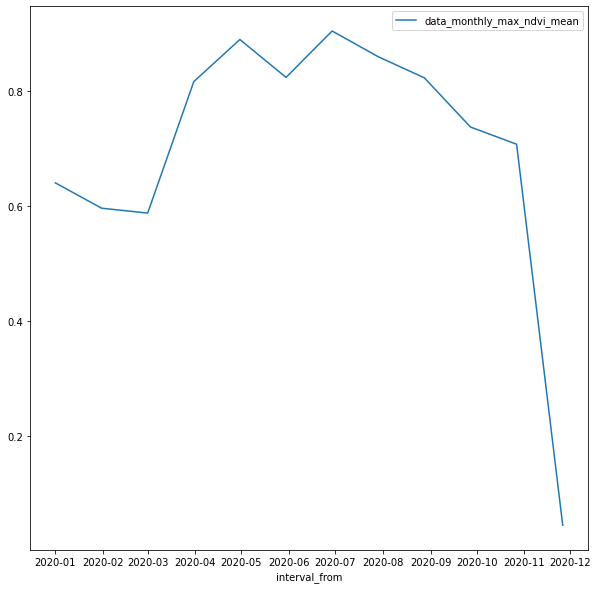

In [14]:
response[ '2020' ]._dfs[ 0 ].plot( figsize=(10,10), x='interval_from', y='data_monthly_max_ndvi_mean')

### _Repeat NDVI Statistical Analysis for 2019_

In [15]:
# define aggregation timeframe
from datetime import datetime
timeframe = { 'start' : datetime.strptime('2019-01-01', '%Y-%m-%d'), 
              'end' : datetime.strptime('2019-12-31', '%Y-%m-%d') }

In [16]:
# submit request
response[ '2019' ] = client.getStatistics( [ timeframe ], resolution=10, polygons=gdf, interval='P30D' )

In [17]:
response[ '2019' ]._dfs[ 0 ]

,id,interval_from,interval_to,data_monthly_max_ndvi_min,data_monthly_max_ndvi_max,data_monthly_max_ndvi_mean,data_monthly_max_ndvi_stDev,data_monthly_max_ndvi_sampleCount,data_monthly_max_ndvi_noDataCount
0,geom_0,2019-01-01,2019-01-31,0.485149,0.850965,0.631411,0.064462,3036,1192
1,geom_0,2019-01-31,2019-03-02,0.389908,0.768480,0.539495,0.060458,3036,1192
2,geom_0,2019-03-02,2019-04-01,0.376801,0.809939,0.573249,0.070975,3036,1192
3,geom_0,2019-04-01,2019-05-01,0.582252,0.871898,0.771485,0.042601,3036,1192
4,geom_0,2019-05-01,2019-05-31,0.694432,0.877473,0.811056,0.023321,3036,1192
5,geom_0,2019-05-31,2019-06-30,0.799440,0.901928,0.863702,0.015110,3036,1192
6,geom_0,2019-06-30,2019-07-30,0.813036,0.922197,0.890588,0.014459,3036,1192
7,geom_0,2019-07-30,2019-08-29,0.798567,0.931603,0.871547,0.018963,3036,1192
8,geom_0,2019-08-29,2019-09-28,0.731110,0.921393,0.870986,0.020588,3036,1192
9,geom_0,2019-09-28,2019-10-28,0.682927,0.871300,0.808049,0.024474,3036,1192


### _Plot Time Series with standard deviation error bars_

In [18]:
for year in [ '2019', '2020' ]:
    response[ year ]._dfs[ 0 ][ 'pos_range' ] = response[ year ]._dfs[ 0 ][ 'data_monthly_max_ndvi_mean' ] + response[ year ]._dfs[ 0 ][ 'data_monthly_max_ndvi_stDev' ]
    response[ year ]._dfs[ 0 ][ 'neg_range' ] = response[ year ]._dfs[ 0 ][ 'data_monthly_max_ndvi_mean' ] - response[ year ]._dfs[ 0 ][ 'data_monthly_max_ndvi_stDev' ]

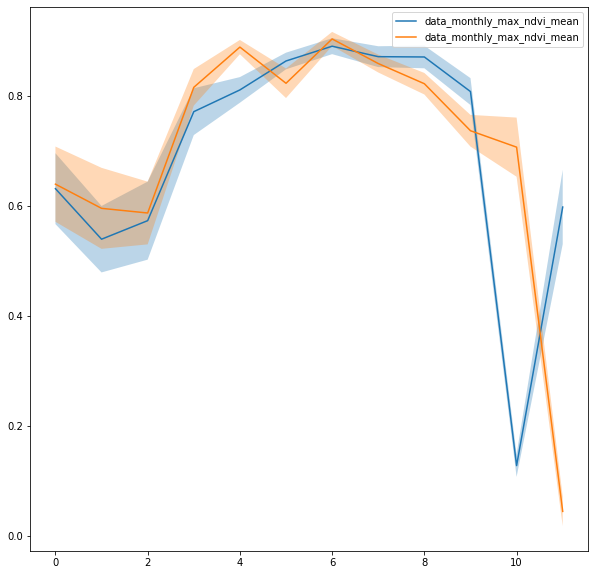

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots( figsize=(10,10) )

for year in [ '2019', '2020' ]:
    response[ year ]._dfs[ 0 ].plot( ax=ax, y='data_monthly_max_ndvi_mean' )
    ax.fill_between( response[ year ]._dfs[ 0 ].index, response[ year ]._dfs[ 0 ][ 'neg_range' ], response[ year ]._dfs[ 0 ][ 'pos_range' ], alpha=0.3 )